In [31]:
import triton
import triton.language as tl

# not on blackwell / hopper, using raw ptrs (not descriptors), no FP8
# my triton is old - descriptors are still experimental!

# took a lot of time to debug the fwd kernel, slept at 3AM yesterday
# hope backprop is faster

configs = [
    triton.Config({'BLOCK_M': 64, 'BLOCK_N': 16}, num_stages=2, num_warps=4),
    triton.Config({'BLOCK_M': 64, 'BLOCK_N': 32}, num_stages=2, num_warps=4),
    triton.Config({'BLOCK_M': 128, 'BLOCK_N': 128}, num_stages=2, num_warps=4),
    triton.Config({'BLOCK_M': 128, 'BLOCK_N': 32}, num_stages=2, num_warps=8),
    triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64}, num_stages=3, num_warps=8),
    triton.Config({'BLOCK_M': 256, 'BLOCK_N': 64}, num_stages=3, num_warps=8),
]

@triton.jit
def _attn_fwd_kv_loop(
    # putting variables in scope...
    on_band,
    low, high, head_start, scale,
    q, ptr_k, ptr_v,
    offs_n: tl.constexpr, offs_row_q, offs_col: tl.constexpr,
    max_r, expsum_r, output,
    HEAD_DIM: tl.constexpr, BLOCK_N: tl.constexpr
):
    # for each row-tile of Q, loop through the K,V of tokens in range(low, high)
    for off_n in tl.range(low, high, BLOCK_N):
        # offsets of kv within a head
        offs_row_kv = off_n + offs_n
        k = tl.load(ptr_k + (head_start + offs_row_kv)[:, None] * HEAD_DIM + offs_col)
        v = tl.load(ptr_v + (head_start + offs_row_kv)[:, None] * HEAD_DIM + offs_col)
        k = k.T
        # dot product of Q [pid_m] x K [low - high]
        qk = tl.dot(q, k) * scale
        if on_band:
            causal_mask = (offs_row_q[:, None]) >= (offs_row_kv[None, :])
            qk = qk + tl.where(causal_mask, 0, -1.0e9)
        max_r_now = tl.maximum(max_r, tl.max(qk, 1))
        qk = qk - max_r_now[:, None]
        exp_qk = tl.math.exp2(qk)
        alpha = tl.math.exp2(max_r - max_r_now)
        # sum across columns - row-wise sum
        expsum_r_now = tl.sum(exp_qk, 1)
        
        output = output * (alpha[:, None])

        exp_qk = exp_qk.to(tl.float16)
        # for every entry, compute and add weight-avged values
        # use tensor cores: exp_qk(f16), v(f16), output(f32)
        output = tl.dot(exp_qk, v, output)

        expsum_r = expsum_r * alpha + expsum_r_now
        max_r = max_r_now
    return output, expsum_r, max_r

@triton.autotune(configs=configs, key=['Z', 'H', 'N', 'HEAD_DIM'])
@triton.jit
def _attn_fwd (
    scale, # scaling factor 1/sqrt(d_k)
    ptr_b, # output tensor to store \log\sum_j\exp(A_{ij}) per row 
            # to be used in backward 
            # dimension: (Z * H * N, 1)
    Z, # batch size
    H, # number of heads
    N, # number of tokens
    ptr_q, # pointer to Q (Z * H * N, HEAD_DIM)
            # each row of Q corresponds to a query from a specific token in a specific head & batch
    ptr_k, # pointer to K
    ptr_v, # pointer to V (d_v = d_k)
    ptr_o, # pointer to O
    HEAD_DIM: tl.constexpr, # d^h_k
    BLOCK_M: tl.constexpr, # tile size in query direction
    BLOCK_N: tl.constexpr, # ... in token sequence direction
):
    # to avoid thinking about masking, I assume:
    # 1. N is a multiple of BLOCK_M (checked outside, since N is not constexpr)
    # 2. BLOCK_N is a multiple of BLOCK_M
    tl.static_assert(BLOCK_M % BLOCK_N == 0) 

    pid_m = tl.program_id(0) # row-tile block-id (which BLOCK_M of the Query for a specific batch & head)
    pid_hz = tl.program_id(1) # which batch and head we are in
    # we could use a 3D launch grid, but 2D might have slightly less overhead for triton
    # batch & head id
    pid_z = pid_hz // H
    pid_h = pid_hz % H

    # the range of the current head
    head_start = pid_z * (H * N) + pid_h * N
    # head_end = head_start + N

    # row offset: from head_start, moving down pid_m blocks
    off_m = pid_m * BLOCK_M
    offs_m = tl.arange(0, BLOCK_M)
    # offsets in q within a head
    offs_row_q = off_m + offs_m

    # initialize running statistics (sftmax) in SRAM / Registers
    max_r = tl.zeros([BLOCK_M], dtype=tl.float32) - float("inf")
    expsum_r = tl.zeros([BLOCK_M], dtype=tl.float32) + 1.0
    output = tl.zeros([BLOCK_M, HEAD_DIM], dtype=tl.float32)

    # becasue we use powers of 2 (faster) and exp(e) = 2^(x * log_2e)
    scale = scale * 1.44269504

    # we recompote offs_row adhoc to reduce register pressure
    # offs_row (head_start + off_m + offs_m)
    offs_col = tl.arange(0, HEAD_DIM) # shape (HEAD_DIM,)
    
    q = tl.load(ptr_q + (head_start + offs_row_q)[:, None] * HEAD_DIM + offs_col[None, :])

    offs_n = tl.arange(0, BLOCK_N)

    # when off-band...
    low, high = 0, pid_m * BLOCK_M
    output, expsum_r, max_r= _attn_fwd_kv_loop(0, low, high, 
                    head_start, scale,
                    q, ptr_k, ptr_v,
                    offs_n, offs_row_q, offs_col, 
                    max_r, expsum_r, output,
                    HEAD_DIM, BLOCK_N)

    # when on-band..
    low, high = pid_m * BLOCK_M, tl.minimum((pid_m + 1) * BLOCK_M, N)
    output, expsum_r, max_r = _attn_fwd_kv_loop(1, low, high, head_start, scale,
                    q, ptr_k, ptr_v,
                    offs_n, offs_row_q, offs_col, 
                    max_r, expsum_r, output,
                    HEAD_DIM, BLOCK_N)

    output = output / expsum_r[:, None]
    # B stores log(sum exp)
    tl.store(ptr_b + (head_start + offs_row_q), max_r + tl.math.log2(expsum_r))
    tl.store(ptr_o + (head_start + offs_row_q)[:, None] * HEAD_DIM + offs_col[None, :], output.to(tl.float16))

In [ ]:
@triton.jit
def _attn_bwd_prep(
    O, DO,
    Delta,
    Z, H, N,
    BLOCK_M: tl.constexpr,
    HEAD_DIM: tl.constexpr
):
    pid_m = tl.program_id(0)
    off_hz = tl.program_id(1)
    offs_m = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, HEAD_DIM)
    o = tl.load(O + (off_hz * N + offs_m[:, None]) * HEAD_DIM + offs_n[None, :])
    do = tl.load(DO + (off_hz * N + offs_m[:, None]) * HEAD_DIM + offs_n[None, :]).to(tl.float32)
    delta = tl.sum(o * do, axis=1)
    tl.store(Delta + off_hz * N + offs_m, delta)

@triton.jit
def _attn_bwd(
    Q, K, V, scale,
    DO, DQ, DK, DV,
    M, D,
    Z, H, N,
    BLOCK_M1: tl.constexpr,
    BLOCK_N1: tl.constexpr,
    BLOCK_M2: tl.constexpr,
    BLOCK_N2: tl.constexpr,
    ON_BAND_SLICE_SIZE: tl.constexpr,
    HEAD_DIM: tl.constexpr
):
    pid = tl.program_id(0)

=== GPU Specs ===
Name: NVIDIA RTX A6000
SM Count: 84
Device Memory: 49139 MB
Compute Capability: 8.6

=== Correctness Test ===
Results match

=== Running Sequence Length Benchmark ===


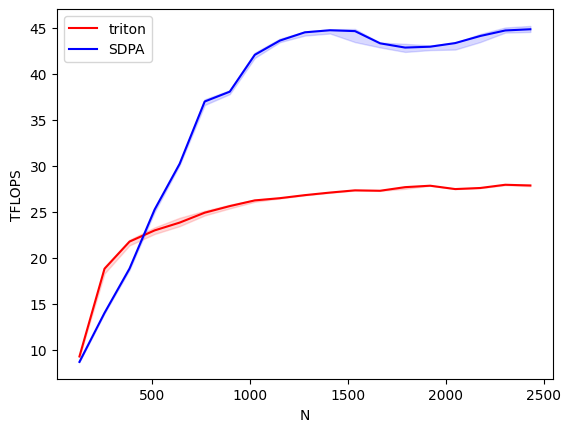

flash-attention-forward:
         N     triton       SDPA
0    128.0   9.309091   8.714893
1    256.0  18.832184  14.033405
2    384.0  21.780798  18.856266
3    512.0  22.995089  25.254721
4    640.0  23.841676  30.228783
5    768.0  24.918630  36.991156
6    896.0  25.632694  38.057170
7   1024.0  26.253780  42.060812
8   1152.0  26.494389  43.604534
9   1280.0  26.823838  44.503598
10  1408.0  27.101353  44.725639
11  1536.0  27.344647  44.632915
12  1664.0  27.298591  43.307985
13  1792.0  27.691666  42.845417
14  1920.0  27.847107  42.940010
15  2048.0  27.482909  43.334064
16  2176.0  27.599535  44.103727
17  2304.0  27.950801  44.704334
18  2432.0  27.871561  44.834931


In [33]:
import torch
import triton
import triton.language as tl

DEVICE = torch.device("cuda:0")

def test_attn_fwd():
    torch.manual_seed(0)
    Z, H, N, D = 2, 4, 256, 128
    scale = 1.0 / (D ** 0.5)
    
    Q = torch.randn(Z, H, N, D, dtype=torch.float16, device=DEVICE).contiguous()
    K = torch.randn(Z, H, N, D, dtype=torch.float16, device=DEVICE).contiguous()
    V = torch.randn(Z, H, N, D, dtype=torch.float16, device=DEVICE).contiguous()

    Q_flat = Q.reshape(Z * H * N, D).contiguous()
    K_flat = K.reshape(Z * H * N, D).contiguous()
    V_flat = V.reshape(Z * H * N, D).contiguous()

    O = torch.empty_like(Q_flat)
    B = torch.empty(Z * H * N, dtype=torch.float32, device=DEVICE)

    # Use lambda grid that accesses autotuner's BLOCK_M
    grid = lambda meta: (triton.cdiv(N, meta['BLOCK_M']), Z * H)
    
    # Triton implementation with warp_specialize
    _attn_fwd[grid](
        scale, B, Z, H, N,
        Q_flat, K_flat, V_flat, O,
        HEAD_DIM=D
    )

    # PyTorch reference
    ref = torch.nn.functional.scaled_dot_product_attention(
        Q.float(), K.float(), V.float(), attn_mask=None, dropout_p=0.0, is_causal=True
    ).to(torch.float16)
    ref_flat = ref.reshape(-1, D)

    torch.testing.assert_close(O, ref_flat, atol=1e-2, rtol=1e-2)
    print("Results match")

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[128 * i for i in range(1, 20)],
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['triton', 'SDPA'],
        styles=[('red', '-'), ('blue', '-')],
        ylabel='TFLOPS',
        plot_name='flash-attention-forward',
        args={'Z': 100, 'H': 8, 'HEAD_DIM': 128, 'dtype': torch.float16},
    ))
def bench_flash_attention(Z, H, N, HEAD_DIM, dtype, provider, device=DEVICE):
    """Benchmark flash attention against PyTorch SDPA"""
    torch.manual_seed(42)
    scale = 1.0 / (HEAD_DIM ** 0.5)
    
    Q = torch.randn(Z, H, N, HEAD_DIM, dtype=dtype, device=device, requires_grad=False)
    K = torch.randn(Z, H, N, HEAD_DIM, dtype=dtype, device=device, requires_grad=False)
    V = torch.randn(Z, H, N, HEAD_DIM, dtype=dtype, device=device, requires_grad=False)
    
    quantiles = [0.5, 0.2, 0.8]

    def triton_fwd():
        Q_flat = Q.reshape(Z * H * N, HEAD_DIM).contiguous()
        K_flat = K.reshape(Z * H * N, HEAD_DIM).contiguous()
        V_flat = V.reshape(Z * H * N, HEAD_DIM).contiguous()
        O = torch.empty_like(Q_flat)
        B = torch.empty(Z * H * N, dtype=torch.float32, device=device)
        
        # Use lambda grid for autotuning
        grid = lambda meta: (triton.cdiv(N, meta['BLOCK_M']), Z * H)
        
        _attn_fwd[grid](
            scale, B, Z, H, N,
            Q_flat, K_flat, V_flat, O,
            HEAD_DIM=HEAD_DIM
        )
        return O.reshape(Z, H, N, HEAD_DIM)

    def torch_fwd():
        return torch.nn.functional.scaled_dot_product_attention(
            Q, K, V, attn_mask=None, dropout_p=0.0, is_causal=True
        )

    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(triton_fwd, quantiles=quantiles, rep=100)
    elif provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(torch_fwd, quantiles=quantiles, rep=100)
    
    # Calculate FLOPS: 2 * batch * heads * seq_len^2 * head_dim (QK^T + softmax + AV)
    # For causal attention, roughly half the operations
    flops_per_attention = 2.0 * Z * H * N * N * HEAD_DIM * 0.5  # 0.5 for causal
    tflops = flops_per_attention * 1e-12 / (ms * 1e-3)
    tflops_min = flops_per_attention * 1e-12 / (max_ms * 1e-3)  
    tflops_max = flops_per_attention * 1e-12 / (min_ms * 1e-3)
    
    return tflops, tflops_min, tflops_max

if __name__ == "__main__":
    print("=== GPU Specs ===")
    specs = torch.cuda.get_device_properties(DEVICE)
    print(f"Name: {specs.name}")
    print(f"SM Count: {specs.multi_processor_count}")
    print(f"Device Memory: {specs.total_memory // (1024 ** 2)} MB")
    print(f"Compute Capability: {specs.major}.{specs.minor}")
    
    print("\n=== Correctness Test ===")
    test_attn_fwd()
    
    print("\n=== Running Sequence Length Benchmark ===")
    bench_flash_attention.run(show_plots=True, print_data=True)
